In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Importamos los modelos y herramientas de Scikit-Learn
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif, chi2, RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
from sklearn.model_selection import cross_val_score

# Importamos los modelos de Gradient Boosting
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import json

# Configuraciones de visualización
%matplotlib inline
sns.set_style('whitegrid')
pd.set_option('display.max_columns', None)

# --- Constantes del Proyecto ---
TARGET = 'churn'

In [10]:
# Carga de datos de entrenamiento y prueba ya limpios
try:
    df_train_clean = pd.read_csv('../data/processed/train_clean.csv', sep=';')
    df_test_clean = pd.read_csv('../data/raw/test.csv', sep=';') # Cargamos el test crudo para procesarlo
except FileNotFoundError as e:
    print(f"Error: No se encontró el fichero de datos. Asegúrate de que la ruta es correcta.")
    print(e)

print("Datos de entrenamiento limpios cargados:", df_train_clean.shape)
print("Datos de prueba crudos cargados:", df_test_clean.shape)

df_train_clean.head()

Datos de entrenamiento limpios cargados: (79830, 109)
Datos de prueba crudos cargados: (20000, 100)


,rev_Mean,mou_Mean,totmrc_Mean,da_Mean,ovrmou_Mean,ovrrev_Mean,vceovr_Mean,datovr_Mean,roam_Mean,change_mou,change_rev,drop_vce_Mean,drop_dat_Mean,blck_vce_Mean,blck_dat_Mean,unan_vce_Mean,unan_dat_Mean,plcd_vce_Mean,plcd_dat_Mean,recv_vce_Mean,recv_sms_Mean,comp_vce_Mean,comp_dat_Mean,custcare_Mean,ccrndmou_Mean,cc_mou_Mean,inonemin_Mean,threeway_Mean,mou_cvce_Mean,mou_cdat_Mean,mou_rvce_Mean,owylis_vce_Mean,mouowylisv_Mean,iwylis_vce_Mean,mouiwylisv_Mean,peak_vce_Mean,peak_dat_Mean,mou_peav_Mean,mou_pead_Mean,opk_vce_Mean,opk_dat_Mean,mou_opkv_Mean,mou_opkd_Mean,drop_blk_Mean,attempt_Mean,complete_Mean,callfwdv_Mean,callwait_Mean,months,uniqsubs,actvsubs,new_cell,crclscod,asl_flag,totcalls,totmou,totrev,adjrev,adjmou,adjqty,avgrev,avgmou,avgqty,avg3mou,avg3qty,avg3rev,avg6mou,avg6qty,avg6rev,prizm_social_one,area,dualband,refurb_new,hnd_price,phones,models,hnd_webcap,truck,rv,ownrent,lor,dwlltype,marital,adults,infobase,income,numbcars,HHstatin,dwllsize,forgntvl,ethnic,kid0_2,kid3_5,kid6_10,kid11_15,kid16_17,creditcd,eqpdays,Customer_ID,churn,infobase_isnull,rev_Mean_isnull,hnd_price_isnull,change_rev_isnull,avg6rev_isnull,lor_isnull,adults_isnull,income_isnull,numbcars_isnull
0,137.4925,784.00,50.0000,3.96,272.50,81.750,81.750,0.0,1.7825,-704.00,-86.7125,3.333333,0.0,30.666667,0.0,19.666667,0.0,233.000000,0.0,91.333333,0.0,180.333333,0.0,0.000000,0.0,0.000000,30.333333,2.000000,286.536667,0.0,273.643333,33.666667,23.993333,0.000000,0.000000,204.000000,0.0,462.530000,0.0,63.333333,0.0,97.650000,0.0,34.000000,233.000000,180.333333,0.0,6.333333,20,1,1,U,BA,N,7810,15986.0,2312.52,2257.35,15960.0,7789,118.81,840.00,409.95,1019,445,166,941.0,441.0,143.0,U,CHICAGO AREA,Y,N,59.98999,1.0,1.0,WCMB,0.0,0.0,O,15.0,S,M,4.0,M,7.0,1.0,C,A,0.0,Z,U,U,U,U,U,Y,601.0,1039302,1,0,0,0,0,0,0,0,0,0
1,59.0650,1702.25,59.9900,0.00,30.25,9.075,9.075,0.0,0.0000,264.75,-9.0750,9.000000,0.0,6.666667,0.0,41.333333,0.0,235.666667,0.0,47.000000,0.0,179.666667,0.0,0.333333,2.0,1.843333,15.666667,0.000000,846.830000,0.0,282.223333,79.333333,191.696667,12.666667,62.930000,103.333333,0.0,367.333333,0.0,122.333333,0.0,761.720000,0.0,15.666667,235.666667,179.666667,0.0,7.333333,19,1,1,N,E4,Y,4333,22876.0,1107.83,1017.85,22853.0,4326,59.87,1344.29,254.47,1614,285,62,1458.0,277.0,57.0,S,ATLANTIC SOUTH AREA,Y,N,199.98999,2.0,2.0,WCMB,0.0,0.0,UNKN,5.0,UNKN,U,2.0,UNKN,6.0,1.0,UNKN,UNKN,0.0,N,U,U,U,U,U,N,156.0,1051213,0,1,0,0,0,0,1,1,1,1
2,44.4700,185.25,30.0000,2.97,28.75,11.500,11.500,0.0,0.0000,-70.25,-11.5000,1.000000,0.0,0.000000,0.0,13.333333,0.0,78.333333,0.0,7.333333,0.0,64.000000,0.0,0.000000,0.0,0.000000,5.333333,0.333333,123.030000,0.0,5.976667,2.000000,1.860000,0.000000,0.000000,52.666667,0.0,104.316667,0.0,16.000000,0.0,24.690000,0.0,1.000000,78.333333,64.000000,0.0,0.000000,33,1,1,U,A,N,1928,5774.0,1194.37,1139.68,5622.0,1873,39.30,193.86,64.59,209,81,48,200.0,70.0,40.0,S,NORTHWEST/ROCKY MOUNTAIN AREA,N,N,29.98999,1.0,1.0,UNKN,1.0,0.0,O,15.0,S,M,3.0,M,6.0,2.0,I,A,0.0,N,U,U,Y,U,U,Y,1009.0,1006409,0,0,0,0,0,0,0,0,0,0
3,28.7450,10.75,39.9900,0.00,0.00,0.000,0.000,0.0,0.0000,-3.75,-0.2550,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,11,1,1,U,BA,N,85,150.0,350.94,290.96,144.0,82,29.10,14.40,8.20,12,7,29,13.0,8.0,29.0,U,SOUTHWEST AREA,Y,N,149.98999,1.0,1.0,WCMB,1.0,0.0,O,8.0,S,U,4.0,M,6.0,1.0,UNKN,A,0.0,J,U,U,Y,Y,U,Y,334.0,1057172,0,0,0,0,0,0,0,0,0,1
4,109.1925,1757.50,82.6925,0.00,113.75,45.500,45.500,0.0,0.0000,84.50,-30.2025,19.666667,0.0,1.333333,0.0,159.333333,0.0,528.333333,0.0,175.666667,0.0,349.000000,0.0,35.333333,65.0,40.876667,127.000000,5.666667,1184.570000,0.0,219.053333,59.666667,97.853333,14.000000,67.196667,222.000000,0.0,508.236667,0.0,215.000000,0.0,895.386667,0.0,21.000000,528.333333,349.000000,0.0,15.000000,7,1,1,U,EA,Y,2

In [11]:
import numpy as np

def create_ratio(df, numerator_col, denominator_col, new_col_name, handle_inf_with=0):
    """
    Crea una nueva feature dividiendo dos columnas existentes de forma segura.
    (Versión corregida para evitar FutureWarning)
    """
    df_out = df.copy()
    epsilon = 1e-6
    
    print(f"Creando feature de ratio: '{new_col_name}'...")
    
    # Creamos la nueva columna
    new_col = df_out[numerator_col] / (df_out[denominator_col] + epsilon)
    
    # Corregimos los infinitos y los nulos, y reasignamos el resultado
    # Esta es la forma moderna que evita el 'inplace=True'
    new_col = new_col.replace([np.inf, -np.inf], np.nan).fillna(handle_inf_with)
    
    # Asignamos la columna ya limpia al DataFrame
    df_out[new_col_name] = new_col
    
    return df_out

def preprocess_and_feature_engineer(df, imputation_values=None):
    """
    Aplica la secuencia completa de preprocesamiento y feature engineering a un DataFrame.
    """
    df_processed = df.copy()

    # --- 1. Limpieza Inicial ---
    if 'Customer_ID' in df_processed.columns:
        df_processed = df_processed.drop(columns=['Customer_ID'])
    
    # --- 2. Definición de Tipos de Columnas ---
    numerical_cols = df_processed.select_dtypes(include=np.number).columns.drop(TARGET, errors='ignore').tolist()
    categorical_cols = df_processed.select_dtypes(include=['object', 'category']).columns.tolist()

    # --- 3. Conversión de Binarias Numéricas a Categóricas ---
    binary_cols = [col for col in numerical_cols if df_processed[col].nunique() == 2 and set(df_processed[col].unique()) <= {0, 1, 0.0, 1.0}]
    for col in binary_cols:
        df_processed[col] = df_processed[col].astype(int).astype('category')
        if col in numerical_cols:
            numerical_cols.remove(col)
        categorical_cols.append(col)
        
    # --- 4. Feature Engineering ---
    # a) Ratios
    df_processed = create_ratio(df_processed, 'rev_Mean', 'months', 'rev_per_month')
    df_processed = create_ratio(df_processed, 'mou_Mean', 'months', 'mou_per_month')
    df_processed = create_ratio(df_processed, 'change_mou', 'mou_Mean', 'change_mou_relative')
    
    # b) Binning (Agrupación)
    bins = [-1, 90, 365, 730, df_processed['eqpdays'].max()]
    labels = ['Equipo_Nuevo', 'Equipo_Seminuevo', 'Equipo_Antiguo', 'Equipo_Muy_Antiguo']
    df_processed['eqpdays_binned'] = pd.cut(df_processed['eqpdays'], bins=bins, labels=labels)
    categorical_cols.append('eqpdays_binned') # Añadimos la nueva columna a la lista de categóricas

    # --- 5. Imputación de Nulos (usando valores del train si se proveen) ---
    if imputation_values:
        df_processed.fillna(value=imputation_values, inplace=True)

    # --- 6. One-Hot Encoding ---
    # Eliminamos las categóricas originales que ya no necesitamos después de crear las dummies
    df_final = pd.get_dummies(df_processed, columns=categorical_cols, drop_first=True)
    
    return df_final

# --- Aplicar la función ---
# 1. Procesamos el set de entrenamiento
df_train_processed = preprocess_and_feature_engineer(df_train_clean)

# 2. Procesamos el set de prueba (cargamos los valores de imputación primero)
with open('../data/processed/imputation_values.json', 'r') as f:
    imputation_values_from_train = json.load(f)
df_test_processed = preprocess_and_feature_engineer(df_test_clean, imputation_values=imputation_values_from_train)


print("Preprocesamiento completado.")

Creando feature de ratio: 'rev_per_month'...
Creando feature de ratio: 'mou_per_month'...
Creando feature de ratio: 'change_mou_relative'...
Creando feature de ratio: 'rev_per_month'...
Creando feature de ratio: 'mou_per_month'...
Creando feature de ratio: 'change_mou_relative'...
Preprocesamiento completado.


Ejecutando selección de características con RandomForest...


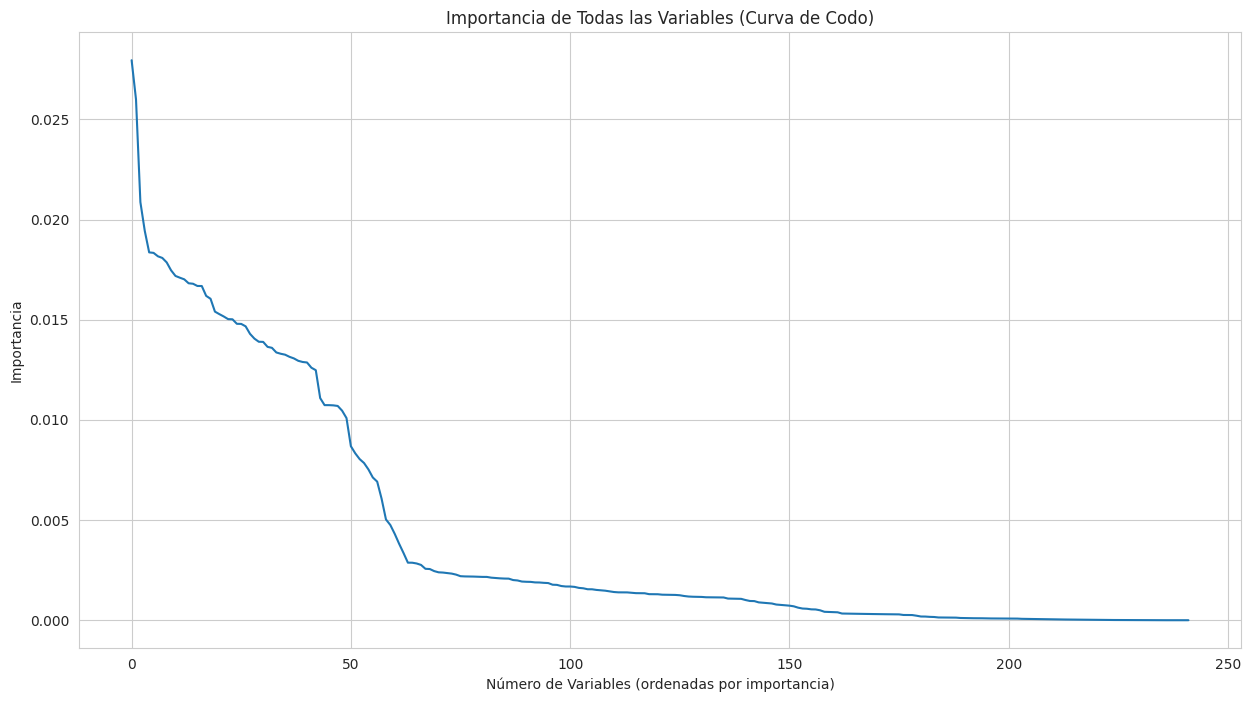


Seleccionadas las 60 mejores características.
Dimensiones de X_train_final: (79830, 60)
Dimensiones de X_test_final: (20000, 60)


In [12]:
# --- 1. Separar X e y del set de entrenamiento ---
y_train = df_train_processed[TARGET]
X_train_full = df_train_processed.drop(columns=[TARGET])

# --- 2. Alinear columnas entre train y test (CRÍTICO) ---
# Nos aseguramos de que ambos dataframes tengan exactamente las mismas columnas
train_cols = X_train_full.columns
test_cols = df_test_processed.drop(columns=[TARGET], errors='ignore').columns

missing_in_test = set(train_cols) - set(test_cols)
for c in missing_in_test:
    df_test_processed[c] = 0

missing_in_train = set(test_cols) - set(train_cols)
for c in missing_in_train:
    X_train_full[c] = 0

df_test_processed = df_test_processed[train_cols] # Asegurar el mismo orden

# --- 3. Selección de Features con RandomForest ---
print("Ejecutando selección de características con RandomForest...")
selector_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
selector_model.fit(X_train_full, y_train)

feature_importance = pd.DataFrame({
    'feature': X_train_full.columns,
    'importance': selector_model.feature_importances_
}).sort_values('importance', ascending=False)

# --- 4. Decidir el número de variables (k) con el método del codo ---
plt.figure(figsize=(15, 8))
plt.plot(range(len(feature_importance)), feature_importance['importance'])
plt.title('Importancia de Todas las Variables (Curva de Codo)')
plt.xlabel('Número de Variables (ordenadas por importancia)')
plt.ylabel('Importancia')
plt.grid(True)
plt.show()

# --- 5. Crear los DataFrames finales para el modelo ---
k = 60  # Valor decidido a partir del gráfico del codo
final_features_list = feature_importance['feature'].head(k).tolist()

X_train_final = X_train_full[final_features_list]
X_test_final = df_test_processed[final_features_list]
y_test = df_test_clean[TARGET] # La y_test viene del fichero limpio antes de OHE

print(f"\nSeleccionadas las {k} mejores características.")
print("Dimensiones de X_train_final:", X_train_final.shape)
print("Dimensiones de X_test_final:", X_test_final.shape)

\n============================================================\n--- ENTRENANDO Y EVALUANDO: RandomForest ---\n============================================================
\n--- AUC en Test: 0.6666 ---
\n--- Informe de Clasificación en Test ---
              precision    recall  f1-score   support

    No Churn       0.62      0.63      0.62     10088
       Churn       0.62      0.61      0.61      9912

    accuracy                           0.62     20000
   macro avg       0.62      0.62      0.62     20000
weighted avg       0.62      0.62      0.62     20000



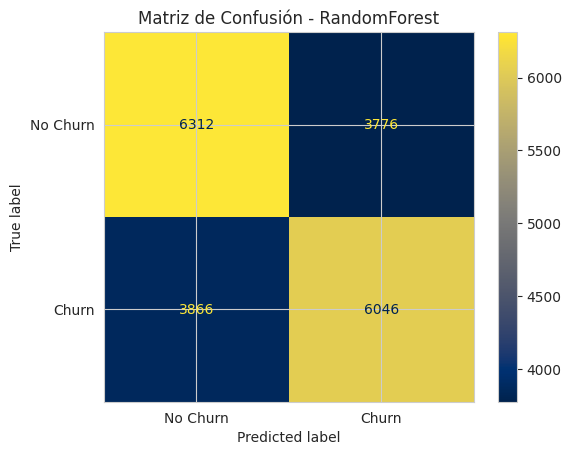

\n============================================================\n--- ENTRENANDO Y EVALUANDO: XGBoost ---\n============================================================
\n--- AUC en Test: 0.6748 ---
\n--- Informe de Clasificación en Test ---
              precision    recall  f1-score   support

    No Churn       0.63      0.61      0.62     10088
       Churn       0.62      0.64      0.63      9912

    accuracy                           0.62     20000
   macro avg       0.62      0.62      0.62     20000
weighted avg       0.62      0.62      0.62     20000



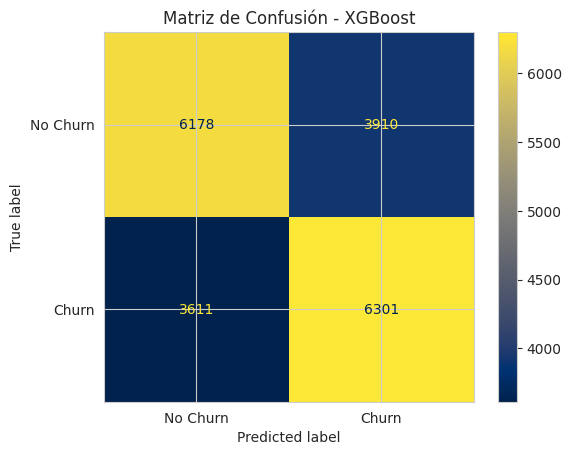

\n============================================================\n--- ENTRENANDO Y EVALUANDO: LightGBM ---\n============================================================
[LightGBM] [Info] Number of positive: 39578, number of negative: 40252
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004937 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13351
[LightGBM] [Info] Number of data points in the train set: 79830, number of used features: 60
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
\n--- AUC en Test: 0.6840 ---
\n--- Informe de Clasificación en Test ---
              precision    recall  f1-score   support

    No Churn       0.64      0.61      0.63     10088
       Churn       0.62      0.65      0.63      9912

    accuracy                           0.63     20000
   macro avg       0.63      0.63      0.63     2

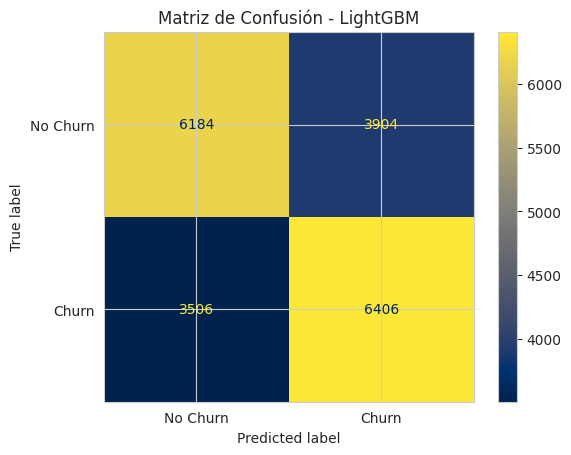

\n==================================================\n--- TABLA RESUMEN DEL TORNEO ---\n==================================================
     model_name  AUC_Test  F1_Score_Churn
2      LightGBM  0.683996        0.633567
1       XGBoost  0.674763        0.626249
0  RandomForest  0.666594        0.612750


In [13]:
def train_and_evaluate_model(model_name, hyperparameters, X_train, y_train, X_test, y_test):
    """Entrena y evalúa un modelo de clasificación, mostrando sus métricas."""
    print(f"\\n{'='*60}\\n--- ENTRENANDO Y EVALUANDO: {model_name} ---\\n{'='*60}")
    
    if model_name == 'RandomForest':
        model = RandomForestClassifier(**hyperparameters)
    elif model_name == 'XGBoost':
        model = XGBClassifier(**hyperparameters)
    elif model_name == 'LightGBM':
        model = LGBMClassifier(**hyperparameters)
    else:
        raise ValueError("Modelo no reconocido.")

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    auc = roc_auc_score(y_test, y_pred_proba)
    print(f"\\n--- AUC en Test: {auc:.4f} ---")
    print("\\n--- Informe de Clasificación en Test ---")
    print(classification_report(y_test, y_pred, target_names=['No Churn', 'Churn']))
    
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Churn', 'Churn'])
    disp.plot(cmap='cividis')
    plt.title(f"Matriz de Confusión - {model_name}")
    plt.show()
    
    return {'model_name': model_name, 'AUC_Test': auc, 'F1_Score_Churn': classification_report(y_test, y_pred, output_dict=True)['1']['f1-score']}

# --- Preparación de Hiperparámetros ---
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]

rf_params = {'n_estimators': 100, 'random_state': 42, 'n_jobs': -1, 'class_weight': 'balanced'}
xgb_params = {'n_estimators': 100, 'random_state': 42, 'n_jobs': -1, 'scale_pos_weight': scale_pos_weight, 'eval_metric': 'logloss'}
lgbm_params = {'n_estimators': 100, 'random_state': 42, 'n_jobs': -1, 'class_weight': 'balanced'}

# --- Ejecución del Torneo ---
all_results = [
    train_and_evaluate_model('RandomForest', rf_params, X_train_final, y_train, X_test_final, y_test),
    train_and_evaluate_model('XGBoost', xgb_params, X_train_final, y_train, X_test_final, y_test),
    train_and_evaluate_model('LightGBM', lgbm_params, X_train_final, y_train, X_test_final, y_test)
]

# --- Tabla Resumen de Resultados ---
results_df = pd.DataFrame(all_results).sort_values(by='AUC_Test', ascending=False)
print("\\n" + "="*50 + "\\n--- TABLA RESUMEN DEL TORNEO ---\\n" + "="*50)
print(results_df)